<h1>Neural Networks Coursework </h1>

CIFAR-10 Image Classification Problem

In [ ]:
# Importing the necessary 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## Task 1 - Read the Dataset and Create Dataloaders

In [ ]:
# Defining the hyperparameters - 

num_epochs = 80
learning_rate = 0.0025
batch_size = 128

train_set = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Testing Set  
test_set = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Download and load the dataset and storing in directories

traindataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_set)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=2)

testdataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=train_set)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=100, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


<b>Displaying Dataset Samples</b> 

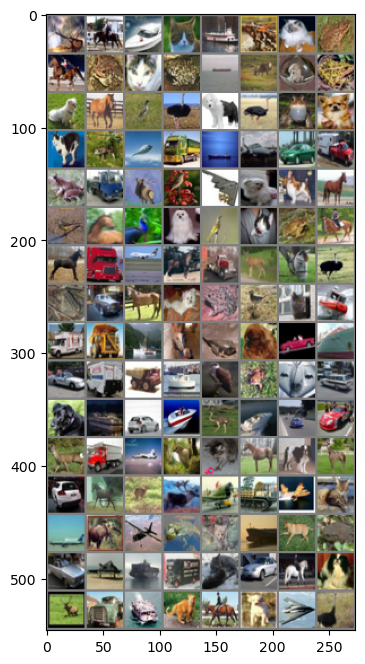

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Functions to show an image -
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # Unnormalizing
    npimg = img.numpy()
    fig = plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Getting random training images 
dataiter = iter(trainloader)
images, labels = next(dataiter)

# image display
imshow(torchvision.utils.make_grid(images))

## Task 2 - Creating the Model 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

# Defining a Block class

class CifarTen(nn.Module):
    def __init__(self, in_channels, out_channels, k=3):
        super(CifarTen, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, k)
        
        # Convolutional layers for the block
        self.convs = nn.ModuleList()
        for _ in range(k):
            conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            
            # Initializing the weights of the convolutional layer - 
            nn.init.kaiming_normal_(conv.weight, mode='fan_in', nonlinearity='relu')
            self.convs.append(conv)
            
        # Residual connection - 
        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )
            # Initializing the weights of the residual connection 
            nn.init.kaiming_normal_(self.residual[0].weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        b, c, _, _ = x.size()
        a = self.fc(self.avg_pool(x).view(b, c))
        a = F.softmax(a, dim=1).view(b, -1, 1, 1)

        # Performing the adaptive convolutions with the calculated weights 
        out = 0
        for i, conv in enumerate(self.convs):
            out += a[:, i:i + 1] * conv(x)
        
        # Adding the residual connection to the output
        res = self.residual(x)
        out += res
        return out

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        
        # Defining the backbone of the model 
        self.backbone = nn.Sequential(
            CifarTen(3, 32),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            CifarTen(32, 32),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            CifarTen(32, 64, k=4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            CifarTen(64, 64, k=4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            CifarTen(64, 128, k=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            CifarTen(128, 128, k=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            CifarTen(128, 256, k=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            CifarTen(256, 256, k=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )
        
    # Defining the forward pass of the model -
    def forward(self, x):
        x = self.backbone(x)         
        x = self.classifier(x)        
        return x
    
model = CustomModel()

## Task 3 - Defining Loss Function & Optimizer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
backbone = CustomModel().to(device)
LossFunc = nn.CrossEntropyLoss()

# Using RMS Prop Optimizer for better results
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate) 

# Define the learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

total_steps = len(trainloader)

## Task 4 - Script to Train the Model 

<b>Training & Validation Functions</b>

In [ ]:
def train_epoch(model, dataloader, LossFunc, optimizer, device, accumulation_steps=4):
     # Model to training mode
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    accumulation_steps = 4
     # Clear the gradients of tensors
    optimizer.zero_grad() 
  
    for i, (images, labels) in enumerate(dataloader):
        # Shiting the images and labels to the device selected
        images, labels = images.to(device), labels.to(device)
        outputs = model(images) 
        loss = LossFunc(outputs, labels)  
        loss.backward() 

        # Updating model parameters 
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()  
            optimizer.zero_grad()  

        running_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class labels
        total += labels.size(0)  # Update the total number of samples
        correct += predicted.eq(labels).sum().item()  # Count the number of correct predictions

    epoch_loss = running_loss / len(dataloader)  # Calculate the average loss for the epoch
    epoch_acc = correct / total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, LossFunc, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Turning off the gradient calculation
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data 
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs, labels to the device

            outputs = model(inputs)  # Forward pass for the model
            loss = LossFunc(outputs, labels)  # Calculate the loss

            running_loss += loss.item()  # Accumulate the loss

            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class labels
            total += labels.size(0)  # Update the total number of samples
            correct += (predicted == labels).sum().item()  # Count the number of correct predictions

    epoch_loss = running_loss / (i + 1)  # Calculate the average loss for the epoch
    epoch_acc = correct / total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_acc

In [ ]:
# Move the model to the device

model.to(device)

# Loop through each batch of data
for images, labels in trainloader:
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass, backward pass, and updating the parameters
    optimizer.zero_grad()
    outputs = model(images)
    loss = LossFunc(outputs, labels)
    loss.backward()
    optimizer.step()

<b> Training the Model & Printing Results </b>

Epoch [2/80], Train Loss: 0.9044, Train Acc: 0.6755, Val Loss: 0.9120, Val Acc: 0.6772
Epoch [4/80], Train Loss: 0.6590, Train Acc: 0.7686, Val Loss: 0.7013, Val Acc: 0.7626
Epoch [6/80], Train Loss: 0.4966, Train Acc: 0.8262, Val Loss: 0.6454, Val Acc: 0.7846
Epoch [8/80], Train Loss: 0.3894, Train Acc: 0.8646, Val Loss: 0.6714, Val Acc: 0.7797
Epoch [10/80], Train Loss: 0.2930, Train Acc: 0.8976, Val Loss: 0.5939, Val Acc: 0.8144
Epoch [12/80], Train Loss: 0.2175, Train Acc: 0.9239, Val Loss: 0.5867, Val Acc: 0.8265
Epoch [14/80], Train Loss: 0.1652, Train Acc: 0.9425, Val Loss: 0.6877, Val Acc: 0.8220
Epoch [16/80], Train Loss: 0.1231, Train Acc: 0.9575, Val Loss: 0.7753, Val Acc: 0.8116
Epoch [18/80], Train Loss: 0.0968, Train Acc: 0.9670, Val Loss: 0.7054, Val Acc: 0.8248
Epoch [20/80], Train Loss: 0.0758, Train Acc: 0.9748, Val Loss: 0.9508, Val Acc: 0.8123
Epoch [22/80], Train Loss: 0.0570, Train Acc: 0.9804, Val Loss: 0.9463, Val Acc: 0.8169
Epoch [24/80], Train Loss: 0.0573, T

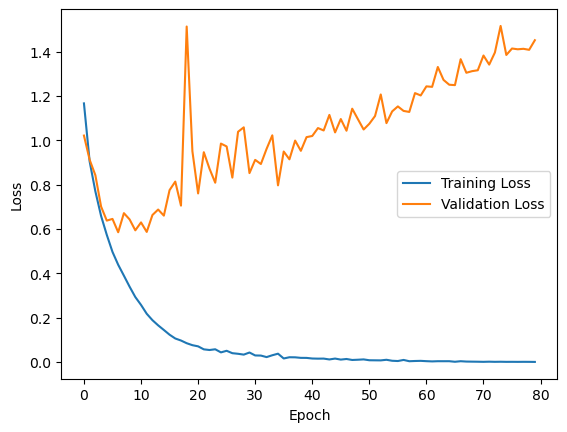

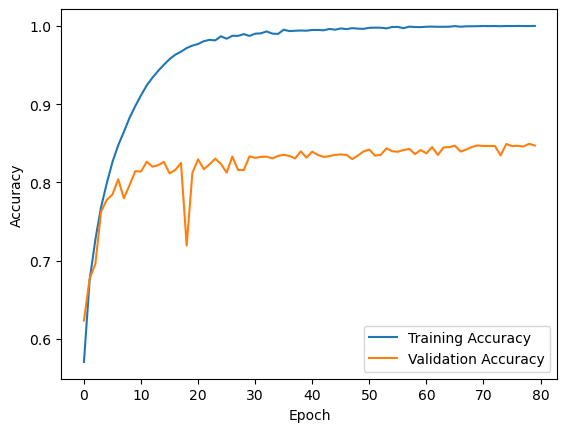

In [ ]:
import time
import matplotlib.pyplot as plt

# Training parameters 
num_epochs = 80
print_every = 2 # prints metrics every 2 Epochs 

# Storing the loss and accuracy history - 
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

start_time = time.time()

# Loop through each epoch
for epoch in range(num_epochs):
    # Train the model for one epoch, calculate training loss and accuracy
    train_loss, train_acc = train_epoch(model, trainloader, LossFunc, optimizer, device)
    # Validate the model and calculate validation loss and accuracy
    val_loss, val_acc = validate_epoch(model, testloader, LossFunc, device)

    # Update the learning rate scheduler at every epoch
    scheduler.step()

    # Store the calculated losses and accuracies for the current epoch
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    # Print the losses and accuracies for the current epoch if satifies condition
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

run_time = time.time()

print(f'Training finished in {(run_time - start_time):.2f} seconds.')

# Plotting the loss curves
plt.figure()
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
 # Saving the Model -

torch.save(backbone.state_dict(), 'model.pt')

## Task 5 - Final Model Accuracy

In [ ]:
print('The training accuracy is: ', train_acc*100)
print('The validation accuracy is: ', val_acc*100)

The training accuracy is:  99.99
The validation accuracy is:  84.71
